# Esercitazione 3

In [1]:
def logistic(z):
    return 1/(1+m.e**(-z))

def log_loss(X, y, a, a0, eta=0):
    ll_sum = 0
    for i in range(X.shape[1]):
        x = X[:,i:i+1]
        guess = logistic(a.T.dot(x)[0][0]+a0)
        if guess in (0,1):
            print('*********', guess)
        ll_sum += y[i]*m.log10(guess) + (1-y[i])*m.log10(1-guess)
    return - ll_sum  + eta*(a**2).sum()  # al valore calcolato sommiamo il regolarizzatore

def logistic_der(X, y, a, a0, delta=0.001, eta=0.0):
    g = np.zeros(a.shape)
    for i in range(a.shape[0]):
        delta_v = np.zeros(a.shape)
        delta_v[i,0] = delta
        g[i, 0] = ( log_loss( X, y, a + delta_v, a0, eta) -\
                   log_loss( X, y, a - delta_v, a0, eta) )\
            / (2*delta)
    g0 = ( log_loss( X, y, a, a0+delta, eta) -\
          log_loss( X, y, a, a0-delta, eta) ) / (2*delta)
    return g, g0

def logistic_dg( X, y, step, eps, max_iter, eta=0):
    curr_a = np.zeros( (X.shape[0], 1) )
    curr_a0 = 0
    
    for t in range(max_iter):
        curr_grad, curr_grad0 = logistic_der(X, y, curr_a, curr_a0)
        
        next_a  = curr_a - step*curr_grad
        next_a0 = curr_a0 - step*curr_grad0
        
        curr_a, curr_a0 = next_a, next_a0
    print('iter:', t)
    return curr_a, curr_a0

## Esercizio 1

Tenendo conto che se

$$
f(z) = y\ln \frac{1}{1+e^{-z}} + (1-y)\ln ( 1 -  \frac{1}{1+e^{-z}} )
$$

allora

$$
f'(z) = y-\frac{1}{1+e^{-z}}
$$

Si modifichi la funzione `logistic_der` in modo che utilizzi $f'$ per calcolare il vettore delle derivate parziali al posto del gradiente numerico.

### Soluzione

Partiamo con l'istanziare $f'$ con il nostro valore di $z$.

![gradiente](gradiente.png)

Nel caso della funzione `log_loss`

![gradiente](gradiente.png)

che implementiamo in questo modo

In [2]:
def logistic_der(X, y, a, a0 ):
    g = np.zeros(a.shape)
    for j in range(a.shape[0]):
        for i in range(X.shape[1]):
            x = X[:,i:i+1]
            g[j, 0] += x[j]*(logistic(a.T.dot(x) + a0 ) -y[i])

    g0 = 0
    for i in range(X.shape[1]):
        x = X[:,i:i+1]
        g0 += logistic(a.T.dot(x) + a0 ) -y[i]  
    
    return g, g0

... che può essere riscritta in modo più razionale nel seguente modo

In [3]:
def logistic_der(X, y, a, a0 ):
    g = np.zeros(a.shape)
    g0 = 0
        
    for i in range(X.shape[1]):
        x = X[:,i:i+1]
        g += x*(logistic(a.T.dot(x) + a0 ) -y[i])
        g0 += logistic(a.T.dot(x) + a0 ) -y[i]  
    
    return g, g0

dove sono stati scambiati le posizioni dei due `for` e sostituito il `for` sugli indici con la somma su vettori.

Un esperimento

iter: 9


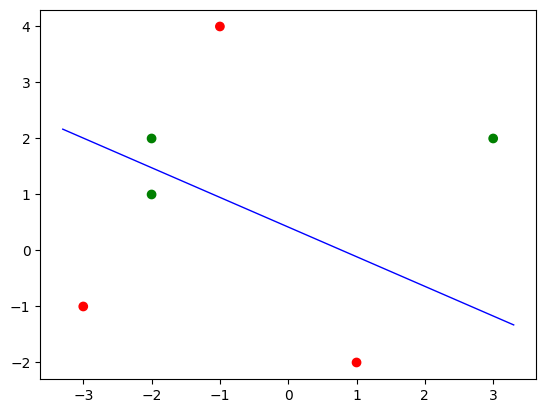

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import math as m

X = [ (3, 2), (-1, 4), (-2, 1), (1,-2), (-3,-1), (-2,2) ]
y = [1,0,1,0,0,1]

X = np.array(X).T

plt.scatter(X[0], X[1], c=['g' if e == 1 else 'r' for e in y])

ax = plt.gca()
xlim_left, xlim_right = ax.get_xlim()
ylim_bottom, ylim_top = ax.get_ylim()

a, a0 = logistic_dg(X, y, step=0.1, eps=0.01, max_iter=10)
a0 = a0[0][0]

plt.plot( ( xlim_left, xlim_right) , [ (-x*a[0][0]-a0)/a[1][0] for x in  (xlim_left, xlim_right) ],\
             linewidth=1, c = 'b', zorder=0 )


## Esercizio 2 (Discesa del gradiente stocastico)

Riprendiamo l'algoritmo della *discesa del gradiente*

![gd_alg](gd_alg.png)

se la funzione $f$ ha questa forma

$$
f(z) = \sum_{i=1}^{n} f_i(z)
$$

(ovvero il caso della `log_loss`), può tornare utile il più efficiente algoritmo della *discesa del gradiente stocastico*

![gd_alg](sgd_alg.png)


Modificare le funzioni riportate nella prima parte del documento in modo da implementare l'algoritmo di discesa del gradiente stocastico

## Esercizio 3

Si consideri la shapefile di punti definita dal file `punti.shp`, dopo aver importato il file in un GeoDataFrame ed averlo convertito in un più conveniente sistema di riferimento, si implementi una funzione che preso il GeoDataFrame ed un `float` `eps` ritorni il punto del DataFrame nel cui intorno di raggio `eps` ricadono più punti.